## Power Trace CDFs and Representative Plots

In [8]:
import argparse
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.stats import pearsonr
from statsmodels.tsa.stattools import acf, pacf
import pandas as pd
import seaborn as sns

from model.core.dataset import PowerTraceDataset
from model.core.utils import load_classifier
from model.predictors.smooth_sampler import SmoothingSampler

In [ ]:
def compute_autocorrelation_metrics(real_trace, synthetic_trace, max_lags=50):
    """
    Compare temporal autocorrelation between real and synthetic traces
    """
    real_acf = acf(real_trace, nlags=max_lags, fft=True)
    synthetic_acf = acf(synthetic_trace, nlags=max_lags, fft=True)
    acf_correlation, _ = pearsonr(real_acf, synthetic_acf)
    acf_mae = np.mean(np.abs(real_acf - synthetic_acf))

    return {
        "real_acf": real_acf,
        "synthetic_acf": synthetic_acf,
        "acf_correlation": acf_correlation,
        "acf_mae": acf_mae,
    }


usage: ipykernel_launcher.py [-h] --data-file DATA_FILE --model
                             {llama-3-8b,llama-3-70b,gpt-oss-20b,gpt-oss-120b}
                             [--hardware_accelerator HARDWARE_ACCELERATOR]
                             [--weights-path WEIGHTS_PATH] [--device DEVICE]
ipykernel_launcher.py: error: the following arguments are required: --data-file, --model


SystemExit: 2

/Users/grantwilkins/anaconda3/envs/ml-inference/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [35]:
data_file = "./model/training_data/vllm-benchmark_llama-3-70b_a100.npz"
model = "llama-3-70b"
hardware_accelerator = "h100"
weights_path = "model/sharegpt_gru_classifier_weights/"
device="cpu"
hw="h100"

In [36]:

dataset = PowerTraceDataset(data_file)
# tp = tp
# Define a consistent color key mapping for TP values
# Using matplotlib's default color cycle for consistency
tp_values = [4]
tp_color_key = {
    1: "#1f77b4",  # blue
    2: "#ff7f0e",  # orange
    4: "#2ca02c",  # green
    8: "#d62728",  # red
}

# Store all CDF data for plotting
cdf_data = []

for tp in tp_values:
    print(f"\nProcessing TP={tp}")
    classifier = load_classifier(
        weights_path + model + f"_{hardware_accelerator}_tp{tp}.pt",
        device=device,
        Dx=dataset.traces[0]["x"].shape[1],
        K=6,
    )
    smoother = SmoothingSampler(dataset)
    tp_indices = [i for i, tp_i in enumerate(dataset.tp_all) if tp_i == tp]

    all_original_power = []
    all_sampled_power = []
    sampled_power_arrs = {}
    import scipy.stats as stats

    min_power = float("inf")
    max_power = float("-inf")
    for idx in tp_indices:
        trace_power = dataset.traces[idx]["y"].flatten()
        min_power = min(min_power, np.min(trace_power))
        max_power = max(max_power, np.max(trace_power))

    plt.clf()
    plt.plot(dataset.traces[tp_indices[0]]["z"].flatten(), color=tp_color_key[tp])
    plt.xlim(0, 50)
    plt.title("State Sequence for First Trace")
    plt.xlabel("Time Step")
    plt.ylabel("State")
    plt.savefig(f"state_sequence_trace_{tp}.pdf")
    plt.close()
    plt.plot(dataset.traces[tp_indices[0]]["y"].flatten(), color=tp_color_key[tp])
    plt.xlim(0, 50)
    plt.title("Power Trace for First Trace")
    plt.xlabel("Time Step")
    plt.ylabel("Power (W)")
    plt.savefig(f"power_trace_{tp}.pdf")
    plt.close()

    for idx in tp_indices:
        time, power, states = smoother.sample_power(
            classifier,
            dataset.mu[tp],
            dataset.sigma[tp],
            dataset.traces[idx]["x"],
            dt=0.25,
            smoothing_window=5,
        )
        power = np.clip(power, min_power, max_power)
        original_power = dataset.traces[idx]["y"].flatten()
        sampled_power = power.flatten()
        sampled_power_arrs[idx] = (time, sampled_power)
        all_original_power.append(original_power)
        all_sampled_power.append(sampled_power)

    all_original_power = np.concatenate(all_original_power)
    all_sampled_power = np.concatenate(all_sampled_power)
    overall_ks_stat, overall_p_value = stats.ks_2samp(
        all_original_power, all_sampled_power
    )
    print(f"Overall - KS Statistic: {overall_ks_stat}, p-value: {overall_p_value}")
    sorted_original_power = np.sort(all_original_power)
    sorted_sampled_power = np.sort(all_sampled_power)

    cdf_original = np.arange(1, len(sorted_original_power) + 1) / len(
        sorted_original_power
    )
    cdf_sampled = np.arange(1, len(sorted_sampled_power) + 1) / len(
        sorted_sampled_power
    )

    # Add data to cdf_data list
    cdf_data.extend(
        [
            {"Power": p, "CDF": c, "Type": "Original", "TP": tp}
            for p, c in zip(sorted_original_power, cdf_original)
        ]
    )
    cdf_data.extend(
        [
            {"Power": p, "CDF": c, "Type": "Sampled", "TP": tp}
            for p, c in zip(sorted_sampled_power, cdf_sampled)
        ]
    )

    print(f"TP={tp} indices:", dataset.tp_all)

    total_energy_original = np.trapz(all_original_power, dx=0.25)
    total_energy_sampled = np.trapz(all_sampled_power, dx=0.25)
    print(f"Total energy consumed (original): {total_energy_original:.2f} J")
    print(f"Total energy consumed (sampled): {total_energy_sampled:.2f} J")
    print(
        f"Energy difference: {total_energy_sampled - total_energy_original:.2f} J"
    )

    # Compute autocorrelation metrics
    print("Computing autocorrelation metrics...")
    autocorr_metrics = compute_autocorrelation_metrics(
        all_original_power, all_sampled_power
    )
    print("Autocorrelation metrics:")
    print(f"ACF Correlation: {autocorr_metrics['acf_correlation']:.4f}")
    print(f"ACF MAE: {autocorr_metrics['acf_mae']:.4f}")

    # Compute earth mover's distance
    from scipy.stats import wasserstein_distance

    emd = wasserstein_distance(sorted_original_power, sorted_sampled_power)
    print(f"Earth Mover's Distance: {emd:.4f}")

    # Calculate p99 error
    p99_original = np.percentile(all_original_power, 99)
    p99_sampled = np.percentile(all_sampled_power, 99)
    p99_error = np.abs(p99_original - p99_sampled) / p99_original * 100
    print(f"P99 Error: {p99_error:.2f}%")

    # Calculate p95 error
    p95_original = np.percentile(all_original_power, 95)
    p95_sampled = np.percentile(all_sampled_power, 95)
    p95_error = np.abs(p95_original - p95_sampled) / p95_original * 100
    print(f"P95 Error: {p95_error:.2f}%")

    # Compute NRMSE
    nrmse = np.sqrt(np.mean((all_original_power - all_sampled_power) ** 2)) / (
        np.max(all_original_power) - np.min(all_original_power)
    )
    print(f"NRMSE: {nrmse:.4f}")


Processing TP=4
Loading classifier from model/sharegpt_gru_classifier_weights/llama-3-70b_h100_tp4.pt on device: cpu


/Users/grantwilkins/powertrace-sim/model/core/utils.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classifier.load_state_dict(torch.load(path, map_location=device))


Overall - KS Statistic: 0.608360446126774, p-value: 0.0
TP=4 indices: [8, 4, 8, 4, 4, 4, 8, 8, 8, 8, 4, 8, 4, 4, 8, 4, 8, 8, 8, 8, 4, 8, 8, 4, 4, 4, 4, 4, 8, 8, 4, 4, 4, 4, 8, 4, 8, 8, 8, 8, 8, 8, 4, 8, 8, 4, 4, 8, 8, 4, 8, 4, 4, 8, 4, 8, 4, 4, 4, 4]
Total energy consumed (original): 20990460.00 J
Total energy consumed (sampled): 9941747.71 J
Energy difference: -11048712.29 J
Computing autocorrelation metrics...
Autocorrelation metrics:
ACF Correlation: 0.9434
ACF MAE: 0.2655
Earth Mover's Distance: 559.5770
P99 Error: 5.50%
P95 Error: 11.48%
NRMSE: 0.5964


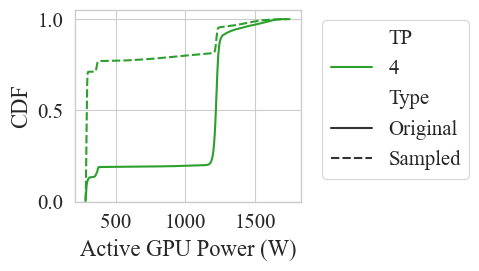

In [37]:
from matplotlib.patches import bbox_artist


df = pd.DataFrame(cdf_data)
if len(df) > 10000:  # If more than 10k points, sample down
    df = df.sample(n=10000, random_state=42)
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.7)
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42
matplotlib.rcParams["font.family"] = "Times New Roman"

# Custom palette: map TP to color via the color key (as str, since seaborn expects str keys for hue)
palette = {tp: tp_color_key[tp] for tp in tp_values}

plt.figure(figsize=(3.5, 3))
sns.lineplot(
    data=df,
    x="Power",
    y="CDF",
    style="Type",
    hue="TP",
    lw=1.5,
    palette=palette,
)
# plt.xlim(0, 1600)
plt.ylim(0, 1.05)
plt.xlabel("Active GPU Power (W)")
plt.ylabel("CDF")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.legend().remove()
plt.savefig(f"cdf-power-trace_{model}_{hw}_combined.pdf", bbox_inches="tight")
# plt.close()